# **PROBLEM STATEMENT**

## **Business Problem**

**What is Mercari?**

Mercari is Japan’s biggest community-powered marketplace. It is like an ebay or OLX in India. Sellers come to this online market-place to sell vast variety of products in various conditions from new to poor.

**Problem Statement**

It can be hard to know how much something’s really worth.<br>
There are a lot of factors that play a vital role in determining the price of a product like brand name, condition of the item, category of the item, specifications of the item, etc. Even a subtle difference in any of the factors can make a huge difference in the price of the product.<br>
For example consider the following two items,<br>
<ul>
<li>Running shoes manufactured by Adidas, soft sole</li>
<li>Running shoes manufactured in local factory, a bit used, soft sole</li>
</ul>
The former one will most likely cost more than the latter.<br>
However, the seller might be confused as to what should be the optimal selling price of the product, such that the price is in accordance with the price at which such prodcut is sold in the market. Such a price will make the buyers willing to buy it and the seller's profit will also not be hurt.

**Business objectives and constraints**

<ul>
<li>The goal is to solve the problem of suggesting the appropriate price of products to online sellers</li>
<li>No latency constraints. Because we would like to suggest a higly accurate price to the seller, even if it takes a reasonable amount of time</li>
</ul>

## **Machine Learning Probelm**

**Data Overview**

The data was uploaded by Mercari on Kaggle, https://www.kaggle.com/c/mercari-price-suggestion-challenge/
<br>
<p>The training file (.tsv) consist of a list of product listings which is tab-delimited.</p>
<ul>
<li>train_id - the id of the listing</li>
<li>name - the title of the listing</li>
<li>item_condition_id - the condition of the items provided by the seller. From 1 to 5. 1 being new and 5 being poor</li>
<li>category_name - category of the listing</li>
<li>brand_name</li>
<li>price - the price that the item was sold for. This is the target variable that we will predict. The unit is USD.
<li>shipping - 1 if shipping fee is paid by seller and 0 by buyer</li>
<li>item_description - the full description of the item.</li>
</ul>
The size of the train.tsv = 322 MB. <br>
Totla number of product listings = 14,82,535

**Type of Machine Learning problem**

<ul>
<li>The prices are in real number. Hence, this problem falls under a regression problem
</li>
</ul>

**Performance Metric**

The metric that we will use is Root Mean Squared Logarithmic Error (RMSLE). The choice of this metric is due to the following reasons,
<ul>
<li>It is robust to outliers</li>
<li>It is scale invariant</li>
<li>It will penalize under-estimation more, than over-estimation. This makes sense from the business perspective, because ideally the company would like to sell the products at a reasonably higher price. This also increases the customer (seller) satisfaction as well as the commission that the company might get for each sale. Another reason is that, the price distribution is highly skewed to the right. Meaning there are a lot of low priced products as compared to very high priced products.
</li>
</ul>

**Train and Test Dataset**

We build train and test by randomly splitting in the ratio of 80:20 as we have sufficient points to work with.

# **DATA INITIZLIZATION**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

!pip install Wordbatch
from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

     |████████████████████████████████| 1.2MB 5.2MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 133kB 13.3MB/s 
     |████████████████████████████████| 2.1MB 12.6MB/s 
  Created wheel for Wordbatch: filename=Wordbatch-1.4.6-cp36-cp36m-linux_x86_64.whl size=2749126 sha256=211ede42b52e33fb9672f63d4dc6b2fdea3e50b76cf91521f1905d171495985e
  Stored in directory: /root/.cache/pip/wheels/66/ec/2a/8e5de8c0526b0713b30c7972bdb06c9b9f509e21cdb6f28d39
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144799 sha256=fbc21123f01aeb4e5b9775255cdde1dfb47ef9994cece31879730e8c9e60195a
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
  Created wheel for py-lz4framed: filename=py_lz4framed-0.14.0-cp36-cp36m-linux_x86_64.whl size=345698 sha256=058ae16e9a58f9703e9db706bdbf33de401247efe302cacf582edfa9f1557d72
  Stored in directory: /root/.cach

In [ ]:
if 'train.tsv' not in os.listdir(): 
    !kaggle competitions download -c mercari-price-suggestion-challenge
    get_ipython().system_raw("7z x \*.7z && rm *.7z")
    get_ipython().system_raw("7z x \*.zip && rm *.zip")

 64% 5.00M/7.77M [00:00<00:00, 5.38MB/s]
100% 7.77M/7.77M [00:01<00:00, 8.02MB/s]
100% 34.0M/34.0M [00:02<00:00, 4.80MB/s]

 99% 292M/294M [00:09<00:00, 81.8MB/s]
100% 294M/294M [00:10<00:00, 30.8MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 56.5MB/s]
 77% 57.0M/74.3M [00:03<00:01, 11.0MB/s]
100% 74.3M/74.3M [00:03<00:00, 20.9MB/s]


In [ ]:
import pandas as pd

train_df = pd.read_csv('train.tsv', sep='\t')

# Price range should be $5-$2000, https://www.mercari.com/us/help_center/article/69
train_df = train_df[train_df['price']>=5]  # Removing the prodicts with prices less than 5
train_df = train_df[train_df['price']<=2000]  # Removing the prodicts with prices more than 2000
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


**Adding log price column**

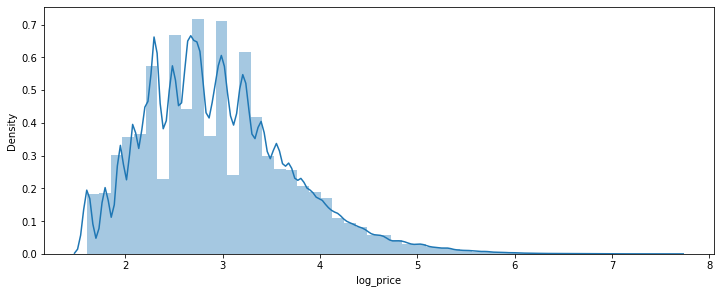

In [ ]:
from scipy import stats

train_df['log_price'] = np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_price'])

**Train Test Split**

In [ ]:
X = train_df.drop(['train_id','log_price','price'], axis=1)
y = train_df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
del X, y, train_df

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1157452, 6)
(1157452,)
(289364, 6)
(289364,)


# **FEATURE ENGINEERING**

### **Filling missing values**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

### **Text Pre-processing**

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def nltk_tag_to_wordnet_tag(nltk_tag):
    # function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def stem_sentence(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    root = []
    for w in words: 
        root.append(ps.stem(w))
    return " ".join(root)

def preprocess_descriptive_text_column(sentance):
    """
    Description:
    This function will process the text data.
    This function will perform decontracting words, removing stop words, removing special characters and then apply stemming on the words in the sentence.

    Input: original sentence
    Output: processed sentence
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    sent = decontract_text(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)

    root_sent = stem_sentence(sent.lower().strip())
    return root_sent

### **Fill Missing Brand Names**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brands_list.pkl', 'rb') as f:
    existing_brands = pickle.load(f)
    
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brand_names_categories_dict.pkl', 'rb') as f:
    brand_names_categories = pickle.load(f)

In [ ]:
def brand_guesser(row):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want our guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe row with missing brand names
    Output: dataframe row with filled brand names
    """
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    brand, name, cn = row
    brand = brand.lower()
    if brand=='unk_brand':
        for brand in existing_brands:
            if brand in name.lower() and cn in brand_names_categories[brand]:
                return brand
            
    return brand

### **Split Categories**

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separates the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then it will remove the original category_name field.

    Input: Dataframe having category_name field
    Output: Dataframe with splitted categories
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

### **Adding Item Description len and Item Name len**

In [ ]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

### **Add is_expensive (sparse)**

In [ ]:
def get_is_expensive_feature(df):
    """
    Description:
    This funciton will generate a feature which will tell if the brand is expensive or not.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'rb') as f:
        expensive_brands = pickle.load(f)
    
    is_expensive_binary = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    sparse_shipping = scipy.sparse.csr_matrix(is_expensive_binary.values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

### **Make Shipping data sparse**

In [ ]:
def get_shipping_feature(df):
    """
    Description:
    This funciton will just get the shipping data in sparse form.

    Input: Dataframe
    Output: Sparse shipping data
    """
    sparse_shipping = scipy.sparse.csr_matrix(df['shipping'].values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

### **Vectorizing data**

In [ ]:
def vectorize_data(col_data, vectorizer=None):
    """
    Description:
    This funciton will vectorize the input column data.

    Input: dataframe column
    Output: one-hot encoded values and the fitted vectorizer
    """
    if vectorizer==None:
        vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
        vectorizer.fit(col_data)
    ohe_data = vectorizer.transform(col_data)
    return ohe_data, vectorizer

### **Feature Engineering pipeline**

In [ ]:
def feature_pipeline(X_data, general_cat_vectorizer=None, subcat_1_vectorizer=None, subcat_2_vectorizer=None, brand_name_vectorizer=None, item_name_vectorizer=None, 
                     item_desc_vectorizer=None, scaler_name_len=None, scaler_desc_len=None):
    """
    Description: This function will do all the feature engineering on the input X_data,
                and create a final data, ready for training.

    Input: Original input dataframe, 
                    the fitted vectorizers for all categorical and text columns [optional: used during inference],
                    scalers [optional: used during inference]
    Output: Featurized data
    """

    print()
    print("Filling missing values...")
    X_data = fill_missing_values(X_data)

    print("pre-processing name text data...")
    X_data['item_description'] = X_data['item_description'].progress_apply(preprocess_descriptive_text_column)
    X_data['name'] = X_data['name'].progress_apply(preprocess_descriptive_text_column)
    X_data['brand_name'] = X_data['brand_name'].progress_apply(lambda x: str(x).lower())

    print("Guessing the missing brands...")
    X_data['brand_name'] = X_data[['brand_name','name', 'category_name']].progress_apply(brand_guesser, axis = 1)

    print("Splitting categories...")
    X_data = split_categories(X_data)

    print('Getting word lengths')
    name_len, scaler_name_len =  get_len_feature(X_data['name'], scaler_name_len)
    desc_len, scaler_desc_len =  get_len_feature(X_data['item_description'], scaler_desc_len)

    print("Getting is_expensive brand feature...")
    sparse_is_expensive = get_is_expensive_feature(X_data)

    print("Getting sparse shipping data...")
    sparse_shipping = get_shipping_feature(X_data)

    print("OHE vectorizing the text and categorical variables...")
    general_cat_ohe, general_cat_vectorizer = vectorize_data(X_data['general_cat'].values.astype('U'), general_cat_vectorizer)
    subcat_1_ohe, subcat_1_vectorizer = vectorize_data(X_data['subcat_1'].values.astype('U'), subcat_1_vectorizer)
    subcat_2_ohe, subcat_2_vectorizer = vectorize_data(X_data['subcat_2'].values.astype('U'), subcat_2_vectorizer)
    brand_name_ohe, brand_name_vectorizer = vectorize_data(X_data['brand_name'].values.astype('U'), brand_name_vectorizer)
    item_name_ohe, item_name_vectorizer = vectorize_data(X_data['name'].values.astype('U'), item_name_vectorizer)
    item_desc_ohe, item_desc_vectorizer = vectorize_data(X_data['item_description'].values.astype('U'), item_desc_vectorizer)

    print("Creating the final featurized dataset...")
    X_featurized = hstack((general_cat_ohe, subcat_1_ohe, subcat_2_ohe, brand_name_ohe, item_name_ohe, item_desc_ohe, 
                            desc_len, name_len, X_data['item_condition_id'].values.reshape(-1,1), sparse_shipping)).tocsr()

    print("Done!!!\n---------------------------\n")
    return X_featurized, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len

In [ ]:
X_tr, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len = feature_pipeline(X_train)
X_te, _, _, _, _, _, _, _, _ = feature_pipeline(X_test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)

In [ ]:
# # https://stackoverflow.com/a/8980156/7697658
# scipy.sparse.save_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/x_train_OHE_wo_binary_brand.npz", X_tr)
# scipy.sparse.save_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/x_test_OHE_wo_binary_brand.npz", X_te)

# **MACHINE LEARNING MODELS**

### **Load training-ready X_tr and X_te**

In [ ]:
X_tr = scipy.sparse.load_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/x_train_OHE_wo_binary_brand.npz")
X_te = scipy.sparse.load_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/x_test_OHE_wo_binary_brand.npz")

In [ ]:
print(X_tr.shape)
print(X_te.shape)

(1157452, 209105)
(289364, 209105)


In [ ]:
def evaluate_model(model, X_data, y_act):
    y_pred = model.predict(X_data)

    act_prices = np.round(np.exp(y_act), 2)
    pred_prices = np.round(np.exp(y_pred), 2)

    rms = np.sqrt(mean_squared_log_error(act_prices.values, pred_prices))
    return rms

def do_inference(model, X_te):
  y_pred = model.predict(X_te)
  pred_prices = np.round(np.exp(y_pred), 2)

  return pred_prices

### **Lasso**

In [ ]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=(0.01, 0.1, 1.0, 10.0), cv=3)
lasso_cv.fit(X_tr, y_train)
rmsl_error = evaluate_model(lasso_cv, X_te, y_test, price_lmbda)
print("Optimal alpha:",lasso_cv.alpha_)
print("RMSLE:",rmsl_error)

Optimal alpha: 0.01
RMSLE: 0.7016356922432011


In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/lasso.pkl', 'wb') as f:
    pickle.dump(lasso_cv,f)

### **Ridge**

In [ ]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), cv=3)
ridge_cv.fit(X_tr, y_train)
rmsl_error = evaluate_model(ridge_cv, X_te, y_test)
print("Optimal alpha:",ridge_cv.alpha_)
print("RMSLE:",rmsl_error)

Optimal alpha: 1.0
RMSLE: 0.43850259833725164


In [ ]:
# Training error
# ----------------
rmsl_error = evaluate_model(ridge_cv, X_tr, y_train)
print(rmsl_error)

0.3836208250725894


In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/ridge.pkl', 'wb') as f:
    pickle.dump(ridge_cv,f)

### **SGDR**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
params = {"loss": ['squared_loss', 'epsilon_insensitive'],
          "alpha": [0.00001, 0.0001,0.001,0.01,0.1,0,1,10],
          "epsilon": [0.001, 0.01, 0.1, 0, 1, 10]    # More epsilon, more regularization, more underfitting
          }

grid_cv = GridSearchCV(SGDRegressor(learning_rate='adaptive'), cv=3, param_grid=params, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_cv.fit(X_tr, y_train)
rmsl_error = evaluate_model(grid_cv, X_te, y_test)
print(rmsl_error)

In [ ]:
rmsl_error = evaluate_model(grid_cv, X_te, y_test)
print(rmsl_error)

0.43594309266301695


In [ ]:
grid_cv.best_params_

{'alpha': 0, 'epsilon': 0.01, 'loss': 'squared_loss'}

In [ ]:
# Training error
# ----------------
rmsl_error = evaluate_model(grid_cv, X_tr, y_train)
print(rmsl_error)

0.39933560338277324


In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/sgdr.pkl', 'wb') as f:
    pickle.dump(grid_cv,f)

### **FM FTRL**

**FM FTRL CV**

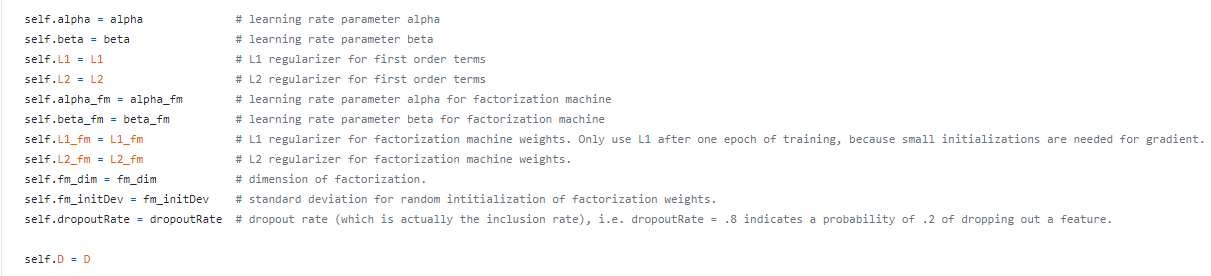

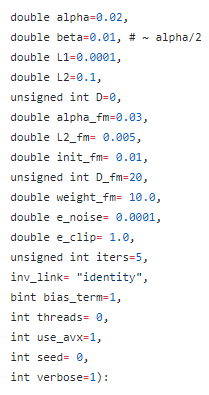

In [ ]:
from wordbatch.models import FTRL, FM_FTRL

d_params = [100,200,300,500,1000]
results_email = ""
try:
    for d in d_params:
        fm_ftrl_model = FM_FTRL(alpha=0.01, L1=0.00001, D=X_tr.shape[1], alpha_fm=0.01, D_fm=d, L2_fm=0.0, iters=25, threads=4)
        fm_ftrl_model.fit(X_tr, y_train)

        rmsl_error = evaluate_model(fm_ftrl_model, X_te, y_test)
        print("D_fm=",d,"\trmsle=",rmsl_error)
        results_email += "D_fm= "+str(d)+"\trmsle= "+str(rmsl_error)+"\n"
    send_email(subject='SUCCESS', body='Log fm_ftrl\n--------------------\n'+results_email)
except Exception as e:
    send_email(subject="MANUAL_FMFTRL FAILURE!!", body="Error: "+str(e))

Total e: 485851.02657925314
Total e: 427194.6362580021
Total e: 411971.6517872273
Total e: 402572.9627587423
Total e: 395731.0420531074
Total e: 390347.98570372915
Total e: 385913.44326959236
Total e: 382154.6233263288
Total e: 378903.1393876849
Total e: 376048.1364439799
Total e: 373510.39920366387
Total e: 371232.50791729114
Total e: 369173.07925133826
Total e: 367298.35095623817
Total e: 365581.7586961416
Total e: 364001.8410713942
Total e: 362540.9822682855
Total e: 361184.5921051547
Total e: 359920.8194636407
Total e: 358738.4809916813
Total e: 357628.6462850338
Total e: 356583.02083737735
Total e: 355595.33029338915
Total e: 354659.78532593173
Total e: 353770.5961434156
D_fm= 100 	rmsle= 0.43280985749378253
Total e: 482993.9048792995
Total e: 424799.9207834195
Total e: 409517.352010842
Total e: 400076.26290905057
Total e: 393186.79774122895
Total e: 387761.0674219786
Total e: 383284.7572277339
Total e: 379487.29475289927
Total e: 376199.31261195755
Total e: 373307.7092401244
Tota

In [ ]:
fm_ftrl_model = FM_FTRL(alpha=0.01, L1=0.00001, D=X_tr.shape[1], alpha_fm=0.01, D_fm=1000, L2_fm=0.0, iters=25, threads=4)
fm_ftrl_model.fit(X_tr, y_train)

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/fm_ftrl.pkl', 'wb') as f:
    pickle.dump(fm_ftrl_model,f)

### **LGBM**

**LGBM CV**

In [ ]:
# Parameters, https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
# Understanding each parameter, https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b
# -------------------------------------------------------------------
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

params = {
    "learning_rate": uniform(0.05,0.7),
    "max_depth": randint(2,10),
    "subsample": uniform(0.2,0.8),
    "colsample_bytree": uniform(0.2,0.8),
    "n_estimators": randint(80,300),
    "reg_alpha": [0.0001,0.001,0.01,0.1,1,10],
    "reg_lambda": [0.0001,0.001,0.01,0.1,1,10]
}

lgb_model = lgb.LGBMRegressor()
rand_cv = RandomizedSearchCV(lgb_model, param_distributions=params, cv=2, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
rand_cv.fit(X_tr, y_train)
rmsl_error = evaluate_model(rand_cv, X_te, y_test)
print(rmsl_error)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 288.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 446.6min finished


0.4599097588478762


In [ ]:
rand_cv.best_params_

{'colsample_bytree': 0.9996365529451683,
 'learning_rate': 0.6688953849701463,
 'max_depth': 9,
 'n_estimators': 284,
 'reg_alpha': 1,
 'reg_lambda': 0.0001,
 'subsample': 0.25871939079599376}

In [ ]:
# import pickle
# with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/lgbm.pkl', 'wb') as f:
#     pickle.dump(rand_cv,f)

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)

### **Stacking Regressor**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/ridge.pkl', 'rb') as f:
    ridge = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/sgdr.pkl', 'rb') as f:
    sgdr = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)

In [ ]:
# Stacking Regressor, http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

ridge = Ridge(alpha=ridge.alpha_)
sgdr = SGDRegressor(**sgdr.best_params_, learning_rate='adaptive')
lgbm = lgb.LGBMRegressor(**lgbm.best_params_)
meta_reg = xgb.XGBRegressor()

params = {
          "meta_regressor__learning_rate": uniform(0.03,0.6),
          "meta_regressor__max_depth": randint(2,10),
          "meta_regressor__subsample": uniform(0.2,0.8),
          "meta_regressor__colsample_bytree": uniform(0.2,0.8),
          "meta_regressor__n_estimators": randint(100,500),
          }

stregr = StackingRegressor(regressors=[ridge, sgdr, lgbm], meta_regressor=meta_reg)

rand_stregr = RandomizedSearchCV(estimator=stregr, param_distributions=params, cv=2, n_iter=20)
rand_stregr.fit(X_tr, y_train)

rmsl_error = evaluate_model(rand_stregr, X_te, y_test)
# Ridge = 0.4385
# SGDR = 0.4360
# LGBM = 0.4599

[06:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:10:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:22:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print(rmsl_error)
rand_stregr.best_params_

0.4283572602901409


{'meta_regressor__colsample_bytree': 0.6591070137492048,
 'meta_regressor__learning_rate': 0.058720102260160105,
 'meta_regressor__max_depth': 5,
 'meta_regressor__n_estimators': 271,
 'meta_regressor__subsample': 0.955988575945949}

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/stacking_reg.pkl', 'wb') as f:
    pickle.dump(rand_stregr,f)

### **Voting Regression**

#### **Using Sklearn's Voting Regressor**

In [ ]:
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
import xgboost as xgb

ridge = Ridge(alpha=ridge.alpha_)
sgdr = SGDRegressor(**sgdr.best_params_, learning_rate='adaptive')
lgbm = lgb.LGBMRegressor(**lgbm.best_params_)

meta_reg = xgb.XGBRegressor(colsample_bytree=0.6591, learning_rate=0.0587, max_depth=5, n_estimators=271, subsample=0.9560)

streg = StackingRegressor(regressors=[ridge, sgdr, lgbm], meta_regressor=meta_reg)

vr = VotingRegressor([('ridge', ridge), ('sgdr', sgdr), ('lgbm', lgbm), ('streg', streg)], n_jobs=-1)
vr.fit(X_tr, y_train)
rmsl_error = evaluate_model(vr, X_te, y_test)
print(rmsl_error)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/voting_reg.pkl', 'wb') as f:
    pickle.dump(vr, f)

In [ ]:
rmsl_error = evaluate_model(vr, X_te, y_test)
print(rmsl_error)

0.42702949095186465


#### **Manual Voting**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/ridge.pkl', 'rb') as f:
    ridge = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/sgdr.pkl', 'rb') as f:
    sgdr = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/stacking_reg.pkl', 'rb') as f:
    streg = pickle.load(f)

# with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/bkp_stacking_reg (ridge and sgdr).pkl', 'rb') as f:
#     streg_bkp = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Best Models log/fm_ftrl_1000.pkl', 'rb') as f:
    fm_ftrl = pickle.load(f)

[03:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
ridge_pred = ridge.predict(X_te)
sgdr_pred = sgdr.predict(X_te)
lgbm_pred = lgbm.predict(X_te)
streg_pred = streg.predict(X_te)
# streg_bkp_pred = streg_bkp.predict(X_te)
fmftrl_pred = fm_ftrl.predict(X_te)

**Best Combo**

In [ ]:
y_pred = fmftrl_pred*0.60 + streg_pred*0.18 + lgbm_pred*0.22

act_prices = np.exp(y_test)
pred_prices = np.exp(y_pred)

rmsl_error = np.sqrt(mean_squared_log_error(act_prices.values, pred_prices))
print(rmsl_error)

0.42100953391066837


**Submission**

In [ ]:
test = pd.read_csv('test_stg2.tsv', sep='\t')

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/vectorizers_scalers.pkl', 'rb') as f:
    general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, \
                                                  brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, \
                                                  scaler_name_len, scaler_desc_len = pickle.load(f)

In [ ]:
X_te, _, _, _, _, _, _, _, _ = feature_pipeline(test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing name text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...


In [ ]:
lgbm_pred = lgbm.predict(X_te)
streg_pred = streg.predict(X_te)
fmftrl_pred = fm_ftrl.predict(X_te)

In [ ]:
y_pred = fmftrl_pred*0.60 + streg_pred*0.18 + lgbm_pred*0.22
submission_prices = np.exp(y_pred)

In [ ]:
my_submission = pd.DataFrame({'test_id': test['test_id'], 'price': submission_prices})
my_submission.to_csv('submission_voting.csv', index=False)

## **Validation Results**

In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "RMSLE"]

pt.add_row(['Lasso','0.7016'])
pt.add_row(['LGBM','0.4599'])
pt.add_row(['Ridge','0.4385'])
pt.add_row(['SGDR','0.4359'])
pt.add_row(['FM FTRL','0.4265'])
pt.add_row(['Stacking Regressor w/ xgb meta','0.4280'])
pt.add_row(['Voting Regressor','0.4210'])

print(pt)

+--------------------------------+--------+
|             Model              | RMSLE  |
+--------------------------------+--------+
|             Lasso              | 0.7016 |
|              LGBM              | 0.4599 |
|             Ridge              | 0.4385 |
|              SGDR              | 0.4359 |
|            FM FTRL             | 0.4265 |
| Stacking Regressor w/ xgb meta | 0.4280 |
|        Voting Regressor        | 0.4210 |
+--------------------------------+--------+


# **Observations**

<ul>
    <li><b>Lasso Regression:</b> This is just an L1 regularized linear regression. This is the worst performing of all models. The reason for which maybe that an L1 regularization is a very strong form of regularization by nature. It brings sparsity to the model. Meaning, it has the capability to reduce the importance/weight of a feature down to zero. So, it will totally discard few of the features.</li>
    <li><b>Ridge Regression:</b> This is just an L2 regularized linear regression. This performs fairly well as compared to Lasso and even the LGBM. An L2 regularization never reduces the feature weights to zero. But it will surely reduce the weights for less important features.</li>
    <li><b>SGD Regression:</b> Unlike the above two regressions, this regression is performed using stochastic gradient descent approach. This has shown to give better results as compared to the above two regressions, where models were created using a 'solver'</li>
    <li><b>LGBM:</b> This is a light version of Gradient Boosting Model. It is a tree ensemble based model. This does not provide any better results as compared to the above discussed three models. The reason for that lies in the nature of this model i.e. 'Tree based model'. Tree based model have shown to not work well on data with very high number of features. Here we have 2,00,000+ features, hence it was bound to not give us better results.</li>
    <li><b>FM FTRL:</b> This model makes use of Factorization Machines (FM) using Follow The Regularized Leader (FTRL) approach. Here we have used 1000 dimensions for the FM. This means, it will take 1000 combinations of the features from the original set of features and create the model using FTRL. This has given us better results than all the above models.</li>
    <li><b>Stacking Regressor:</b> We have used ridge, sgdr and lgbm as the base estimators and xgb regressor as the meta estimator. This is an ensemble technique. This has given us better results than the three regression models (except FM_FTRL). We couldn't include FM_FTRL in the stack, because the FM_FTRL implementation does not have certain elements/functions required for cloning the model's object during stacking. </li>
    <li><b>Voting Regressor:</b> I have used two type of Voting mechanism.
        <ul>
            <li><i>Sklearn's voting regressor:</i> Here we have taken ridge, sgdr, lgbm and the stacking regressor as the base estimators (There is no meta estimator in voting models). This model performs even better than the stacking regressor.</li>
            <li><i>Manual voting:</i> Here I had to weigh the predictions of the more than 1 models manually. After trying several combinations, I chose FM_FTRL, stacking regressor and lgbm regressor as the three models and each of them was weighed according to its individual performance. Surprisingly LGBM model proved to be very useful here even with the least weight. None of the other three models could take its place in giving better final results. </li>
        </ul>
    </li>
</ul>

# **Kaggle Submission Score**

**Sklearn Voting Regressor**

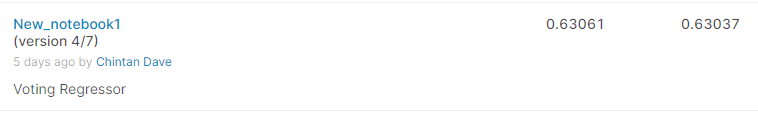

**Manual Voting**

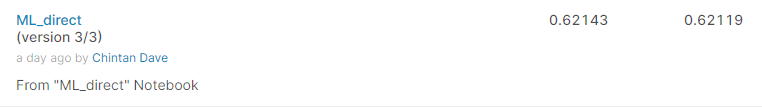